In [32]:
###############
#### hypothesis 2
##############
## For this quera_data is not ok

In [38]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

username = 'root'
user_password = '@Mg89141379@'

cnx = mysql.connector.connect(
    user=username,
    password=user_password,
    host='localhost',
    database='football_data_team'
)


cursor = cnx.cursor()

query = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'football_data_team'"
cursor.execute(query)


results = cursor.fetchall()

# Loop through the table names and create DataFrames for each table
dfs = {}
for row in results:
    table_name = row[0]
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", cnx)
    dfs[table_name] = df
cursor.close()
cnx.close()

C:\Users\mehrs\AppData\Local\Temp\ipykernel_4756\523367221.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(f"SELECT * FROM {table_name}", cnx)
C:\Users\mehrs\AppData\Local\Temp\ipykernel_4756\523367221.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(f"SELECT * FROM {table_name}", cnx)


In [39]:
df = dfs['clubs_season'] 
df = df[df['season'] > 2019]
df = df[df['season'] < 2022]
df['in_Europe'] = 0
# Create separate DataFrames for the 2020 and 2021 seasons
df_2020 = df[df['season'] == 2020]
df_2021 = df[df['season'] == 2021]
# france is Top 3 fro cahmpopns_leauge
clubs_in_europe = df_2020[(df_2020['rank'] < 4) & (df_2020['competition_id'] != 'FR1')]['club_id'].unique()

df_2021.loc[df_2021['club_id'].isin(clubs_in_europe), 'in_Europe'] = 1

fr1_clubs_in_europe = df_2020[(df_2020['competition_id'] == 'FR1') & (df_2020['rank'] < 3)]['club_id'].unique()

df_2021.loc[(df_2021['competition_id'] == 'FR1') & df_2021['club_id'].isin(fr1_clubs_in_europe), 'in_Europe'] = 1


df_2021['points'] =df_2021['win'] * 3 + df_2021['draw']


C:\Users\mehrs\AppData\Local\Temp\ipykernel_4756\624615065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['points'] =df_2021['win'] * 3 + df_2021['draw']


In [40]:
qualified_teams = df_2021[df_2021['in_Europe'] == 1]

qualified_mean_wins = qualified_teams.groupby('competition_id')[['win','draw','loss','goals_scored','goals_conceded','points']].mean()

non_qualified_teams = df_2021[df_2021['in_Europe'] == 0]

non_qualified_mean_wins = non_qualified_teams.groupby('competition_id')[['win','draw','loss','goals_scored','goals_conceded','points']].mean()

In [41]:
for column in qualified_mean_wins.columns:
    if(column=='win' or column=='draw' or column == 'loss'):
        continue
      
    qualified_mean = qualified_mean_wins[column]
    non_qualified_mean = non_qualified_mean_wins[column]
    
    _, p_value = ttest_ind(qualified_mean, non_qualified_mean, equal_var=False)
    
    
    alpha = 0.01
    
    if p_value < alpha:
        print(f"The performance of qualified teams in terms of {column} is significantly better than non-qualified teams.")
    else:
        print(f"The performance of qualified teams in terms of {column} is not significantly different from non-qualified teams.")

The performance of qualified teams in terms of goals_scored is significantly better than non-qualified teams.
The performance of qualified teams in terms of goals_conceded is significantly better than non-qualified teams.
The performance of qualified teams in terms of points is significantly better than non-qualified teams.


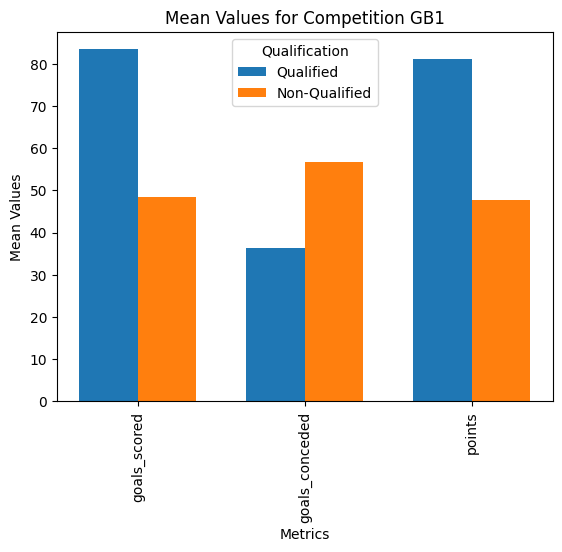

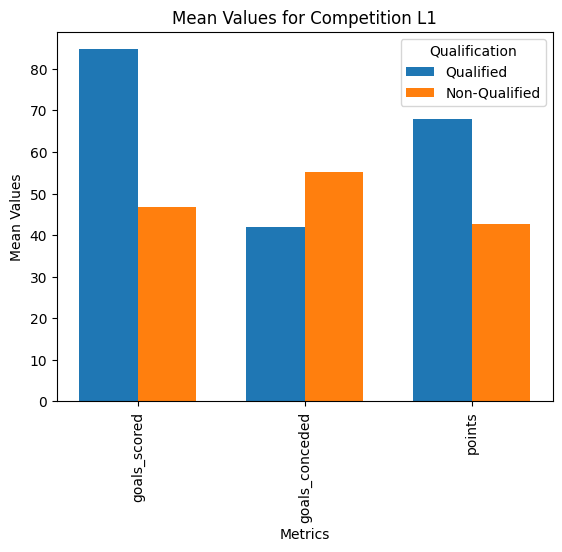

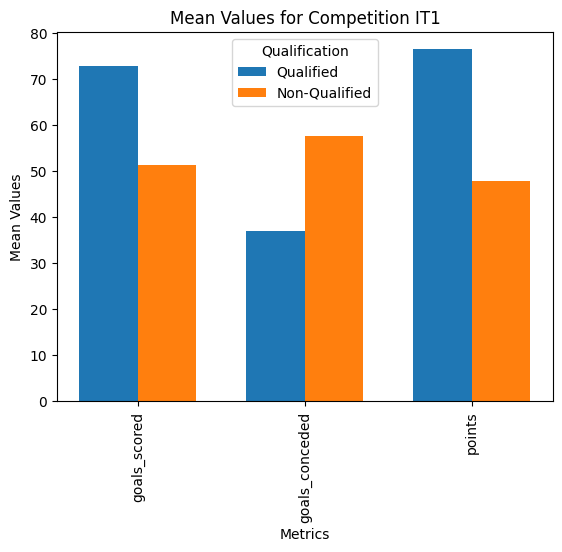

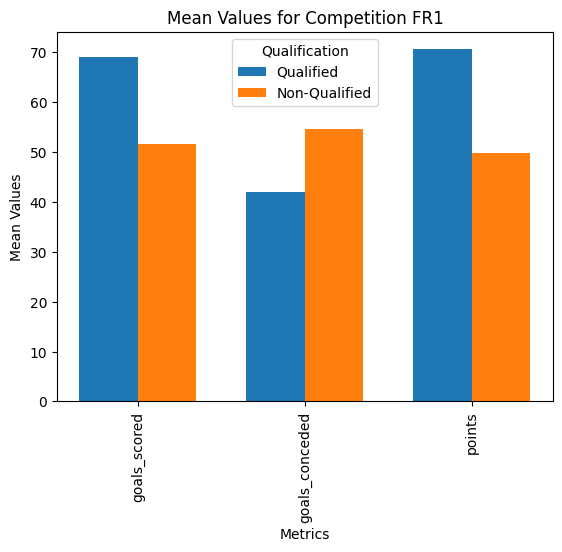

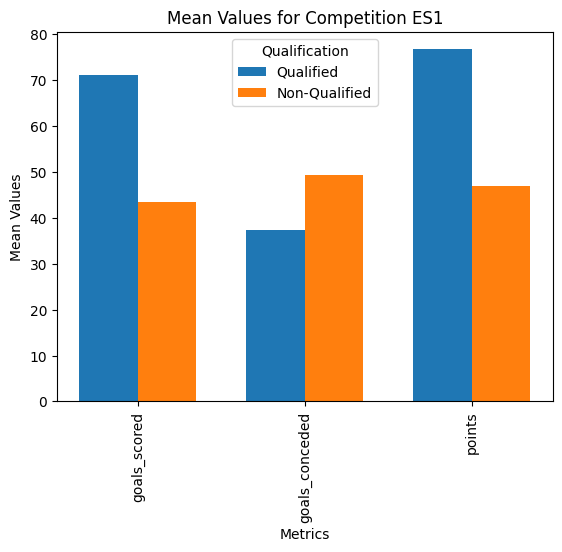

In [42]:
mean_wins_combined = pd.concat([qualified_mean_wins, non_qualified_mean_wins], keys=['Qualified', 'Non-Qualified'])

competition_ids = df_2021['competition_id'].unique()

bar_width = 0.35

for competition_id in competition_ids:

    qualified_mean_wins = qualified_teams[qualified_teams['competition_id'] == competition_id]
    qualified_mean_wins = qualified_mean_wins[[ 'goals_scored', 'goals_conceded','points']].mean()

    non_qualified_mean_wins = non_qualified_teams[non_qualified_teams['competition_id'] == competition_id]
    non_qualified_mean_wins = non_qualified_mean_wins[['goals_scored', 'goals_conceded','points']].mean()
    
    indices = np.arange(len(qualified_mean_wins))

    plt.figure()
    plt.bar(indices, qualified_mean_wins, width=bar_width, label='Qualified')
    plt.bar(indices + bar_width, non_qualified_mean_wins, width=bar_width, label='Non-Qualified')
    plt.xlabel('Metrics')
    plt.ylabel('Mean Values')
    plt.title(f'Mean Values for Competition {competition_id}')
    plt.legend(title='Qualification')
    plt.xticks(indices + bar_width / 2, qualified_mean_wins.index)
    plt.xticks(rotation=90)
    plt.show()
